In [282]:
library(httr2)
library(ggplot2)

# Single day events to test functions with
birthdays <- data.frame(
	name = c("Jamie", "Spandan", "Rex"),
	latitude = c(18.417, 22.6009, 24.9645),
	longitude = c(-64.6192, 88.4052, 121.2575),
	start_date = as.Date(c("1995-08-12", "1999-09-30", "1990-09-23")),
	end_date   = as.Date(c("1995-08-12", "1999-09-30", "1990-09-23")),
	stringsAsFactors = FALSE
)
row.names(birthdays) <- birthdays$name
birthdays$name <- NULL

# Multi-day events to test functions with
canadian_olympics <- data.frame(
	city = c("Montreal", "Calgary", "Vancouver"),
	latitude = c(45.5088, 51.0447, 49.2827),
	longitude = c(-73.5618, -114.0719, -123.1207),
	start_date = as.Date(c("1976-07-17", "1988-02-13", "2010-02-12")),
	end_date   = as.Date(c("1976-08-01", "1988-02-28", "2010-02-28")),
	stringsAsFactors = FALSE
)
row.names(canadian_olympics) <- canadian_olympics$city
canadian_olympics$city <- NULL

# The hourly variables supported by this API wrapper
supported_hourly_variables <- c(
    "temperature_2m",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "relative_humidity_2m",
    "snow_depth",
    "cloud_cover"
)

# The daily variables supported by this API wrapper
supported_daily_variables <- c(
    "temperature_2m_max", 
    "temperature_2m_min", 
    "daylight_duration", 
    "sunshine_duration", 
    "rain_sum", 
    "snowfall_sum", 
    "precipitation_hours", 
    "wind_speed_10m_max"
)

# Function to get the response from the Open-Meteo API 
get_historical_weather_raw <- function(
	latitude,
	longitude,
	start_date,
	end_date,
    daily_variables = c(),
	hourly_variables = c()
) {

    # TODO: Error handling. Validate latitude is between -90 and 90
    # TODO: Error handling. Validate longitude is between -180 and 180
    # TODO: Error handling. Validate start_date is after 1940-01-01
    # TODO: Error handling. Validate end_date is over 5 days ago
    # TODO: Error handling. Validate end_date is after the start_date

    # Calling the Open-Meteo Api
	req <- req_url_query(
		request("https://archive-api.open-meteo.com/v1/archive"),
		latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date   = end_date,
        daily = paste(daily_variables, collapse = ","),
		hourly = paste(hourly_variables, collapse = ",")
	)

    # TODO: Error handling. For resp_status(resp) != 200

	response <- req_perform(req)
    response
}

# Function to get daily historical weather data as a dataframe
get_historical_weather_daily <- function(
	latitude,
	longitude,
	start_date,
	end_date,
	daily_variables = supported_daily_variables
) {

    # TODO: Error handling. Validate every daily variable is in supported_daily_variables

	response <- get_historical_weather_raw(
        latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date = end_date,
        daily_variables = daily_variables
    )
    
	data_json <- resp_body_json(response)
    daily_data <- as.data.frame(lapply(data_json$daily, function(x) unlist(x))) # Making each daily variable a column in the dataframe
    daily_data$time <- as.Date(daily_data$time, format = "%Y-%m-%d") # Making time a date column in the dataframe
    daily_data
}

# Function to get hourly historical weather data as a dataframe
get_historical_weather_hourly <- function(
	latitude,
	longitude,
	start_date,
	end_date,
	hourly_variables = supported_hourly_variables
) {

    # TODO: Error handling. Validate every hourly variable is in supported_hourly_variables

	response <- get_historical_weather_raw(
        latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date = end_date,
        hourly_variables = hourly_variables
    )
    
	data_json <- resp_body_json(response)
    hourly_data <- as.data.frame(lapply(data_json$hourly, function(x) unlist(x))) # Making each hourly variable a column in the dataframe
    hourly_data$time <- as.POSIXct(hourly_data$time, format = "%Y-%m-%dT%H:%M", tz = "UTC") # Making time a datetime column in the dataframe
    hourly_data
}

# Function to get the units for all supported daily variables
get_supported_daily_units <- function() {

    # An arbitrary location and time, just to get variable units from API
    daily_data <- get_historical_weather_raw(
    	49.2593,
    	123.2475,
    	"2020-01-01",
    	"2020-01-01",
        daily = supported_daily_variables
    )
    
    resp_body_json(daily_data)$daily_units
}

# Function to get the units for all supported hourly variables
get_supported_hourly_units <- function() {

    # An arbitrary location and time, just to get variable units from API
    hourly_data <- get_historical_weather_raw(
    	49.2593,
    	123.2475,
    	"2020-01-01",
    	"2020-01-01",
        hourly = supported_hourly_variables
    )
    
    resp_body_json(hourly_data)$hourly_units
}   

# Function to visualize trends in historical weather
plot_feature <- function(dataframe, feature) {

    # TODO: Error handling. Validate feature and time is in dataframe
    
    ggplot(dataframe, aes(x = time, y = .data[[feature]])) +
    	geom_line(color = "yellow") +
    	geom_point(color = "yellow") +
    	labs(x = "Time", y = "Value", title = feature) +
    	theme_dark()
}

In [278]:
canadian_olympics

,latitude,longitude,start_date,end_date
,<dbl>,<dbl>,<date>,<date>
Montreal,45.5088,-73.5618,1976-07-17,1976-08-01
Calgary,51.0447,-114.0719,1988-02-13,1988-02-28
Vancouver,49.2827,-123.1207,2010-02-12,2010-02-28


In [283]:
birthdays

,latitude,longitude,start_date,end_date
,<dbl>,<dbl>,<date>,<date>
Jamie,18.4170,-64.6192,1995-08-12,1995-08-12
Spandan,22.6009,88.4052,1999-09-30,1999-09-30
Rex,24.9645,121.2575,1990-09-23,1990-09-23


In [284]:
vancouver_olympics <- canadian_olympics["Montreal", ]

daily_data <- get_historical_weather_daily(
	vancouver_olympics$latitude,
	vancouver_olympics$longitude,
	vancouver_olympics$start_date,
	vancouver_olympics$end_date
)

head(daily_data, 20)

,time,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1976-07-17,22.3,17.4,54985.07,44917.15,3.5,0,11,19.9
2,1976-07-18,22.8,15.3,54876.63,50400.00,0.7,0,3,22.8
3,1976-07-19,26.7,15.9,54765.43,50400.00,0.4,0,1,24.4
4,1976-07-20,27.6,19.1,54651.59,39969.06,0.5,0,2,27.0
5,1976-07-21,22.9,16.1,54535.24,46800.00,7.9,0,8,23.7
6,1976-07-22,21.6,12.6,54416.52,50400.00,0.0,0,0,12.8
7,1976-07-23,25.9,15.1,54295.35,50370.16,0.3,0,3,19.7
8,1976-07-24,23.5,18.9,54170.69,28957.64,10.6,0,17,23.5
9,1976-07-25,19.0,12.1,54042.54,37213.64,0.0,0,0,18.7


In [285]:
hourly_data <- get_historical_weather_hourly(
	vancouver_olympics$latitude,
	vancouver_olympics$longitude,
	vancouver_olympics$start_date,
	vancouver_olympics$end_date,
)

head(hourly_data, 20)

,time,temperature_2m,rain,snowfall,wind_speed_10m,relative_humidity_2m,snow_depth,cloud_cover
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,1976-07-17 00:00:00,22.3,0.9,0,8.8,86,0,96
2,1976-07-17 01:00:00,20.7,0.3,0,8.9,96,0,100
3,1976-07-17 02:00:00,19.9,0.9,0,10.5,98,0,92
4,1976-07-17 03:00:00,19.7,0.7,0,13.1,98,0,100
5,1976-07-17 04:00:00,19.5,0.1,0,11.8,96,0,94
6,1976-07-17 05:00:00,19.3,0.0,0,10.9,96,0,98
7,1976-07-17 06:00:00,19.0,0.0,0,13.4,96,0,63
8,1976-07-17 07:00:00,18.2,0.0,0,13.4,97,0,45
9,1976-07-17 08:00:00,17.9,0.0,0,12.2,97,0,47


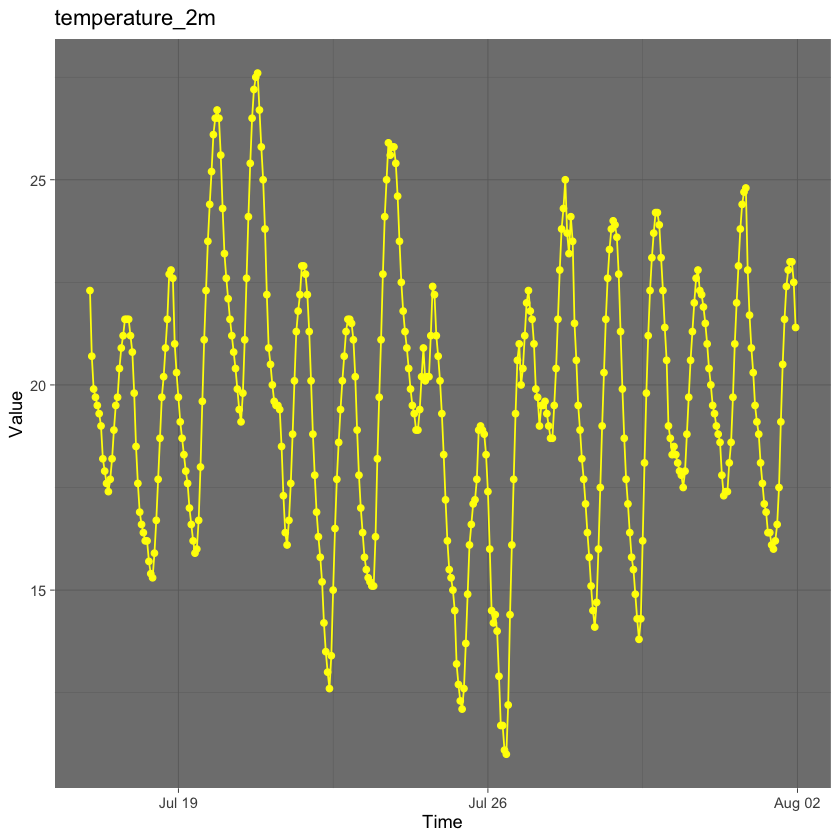

In [286]:
plot_feature(hourly_data, "temperature_2m")